In [6]:
import random
import torch 
from d2l import torch as d2l # 注意d2l是L！

# 3.2.1 生成数据集
 在下面的代码中，我们生成一个包含1000个样本的数据集， 每个样本包含从标
 准正态分布中采样的2个特征。

我们使用线性模型参数 w=[2,−3.4]⊤ 、 b=4.2  和噪声项 ϵ 生成数据集及其标签：

$$ y=Xw+b+ϵ.$$
 
你可以将 ϵ 视为模型预测和标签时的潜在观测误差。 在这里我们认为标准假设成立，即 ϵ 服从均值为0的正态分布。 为了简化问题，我们将标准差设为0.01。 下面的代码生成合成数据集。

In [7]:
def synthetic_data(w,b,num_examples): #@save
    """生成y=Xw+b+噪声"""
    # X从标准正态分布中选；
    X=torch.normal(0,1,(num_examples,len(w))) # torch.nomal：三个参数，第一个是均值，第二个是标准差，第三个是可选的输出张量，决定了输出的size
    y=torch.matmul(X,w)+b # torch.matmul:X和w相乘
    y+=torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1)) # 这里reshape中的-1是由程序自己算，保证列为1


true_w=torch.tensor([2,-3.4])
true_b=4.2
features, labels=synthetic_data(true_w,true_b,1000)


注意，features中的每一行都包含了一个二维数据样本，labels中的每一行都包含一维标签值（一个标量）

通过生成第二个特征features[:,1]和labels的散点图，可以直观观察到两者之间的线性关系。

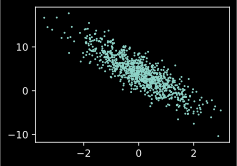

In [8]:
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1)

# 3.2.2 读取数据集
定义一个函数，该函数能打乱数据集中的样本并以小批量方式获取数据。


In [9]:
def data_iter(batch_size,features,labels):
    num_examples=len(features) # 第0维的数值
    indices=list(range(num_examples)) # 生成索引，从0到num_examples-1
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices) # 打乱indices中的值
    for i in range(0,num_examples,batch_size): # start,stop,step
        batch_indices=torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]

In [19]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.0875, -0.9529],
        [-1.3943,  1.7722],
        [-0.1872, -0.6913],
        [-2.0445,  0.4068],
        [ 1.0830,  0.2699],
        [-0.4898,  1.2111],
        [-0.1051,  0.4505],
        [ 1.4778,  0.4735],
        [ 0.3181,  0.0745],
        [-0.5917, -0.0331]]) 
 tensor([[ 7.6341],
        [-4.6159],
        [ 6.1796],
        [-1.2824],
        [ 5.4746],
        [-0.9062],
        [ 2.4606],
        [ 5.5475],
        [ 4.5772],
        [ 3.1252]])


# 3.2.3 初始化模型参数
通过从均值为0，标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0.

In [24]:
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

# 3.2.4 定义模型

In [26]:
def linreg(X,w,b): #@save
    """线性回归模型"""
    return torch.matmul(X,w)+b


# 3.2.5 定义损失函数

In [27]:
def squared_loss(y_hat, y): #@save
    """"均方损失"""
    return (y_hat-y.reshape(y_hat.shape))**2/2

# 3.2.6 定义优化算法

In [28]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# 3.2.7. 训练 

In [29]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.046121
epoch 2, loss 0.000195
epoch 3, loss 0.000052


In [30]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0005, -0.0007], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)
